In [1]:
# inspecting the data of jena weather dataset
import os

data_dir = 'jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
# parsing the data into numpy array
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

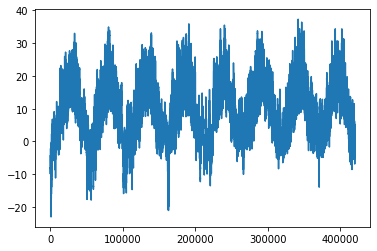

In [3]:
# ploting the temperature
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

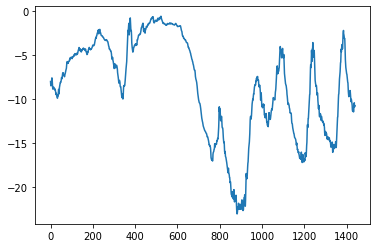

In [4]:
# first 10 days of temperature data recorded every 10 minutes(144 data points per day)
plt.plot(range(1440), temp[:1440])
plt.show()

In [5]:
# normilizing the data
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [8]:
# computing the common-sense baseline MAE
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.2897359729905486


In [12]:
# Training and evaluating a densely connected model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 17s 34ms/step - loss: 1.5290 - val_loss: 0.7344
Epoch 2/20
500/500 [==============================] - 17s 34ms/step - loss: 0.4661 - val_loss: 0.3776
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2966 - val_loss: 0.3122
Epoch 4/20
500/500 [==============================] - 17s 33ms/step - loss: 0.2669 - val_loss: 0.3084
Epoch 5/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2530 - val_loss: 0.3028
Epoch 6/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2445 - val_loss: 0.3110
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2374 - val_loss: 0.3293
Epoch 8/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2304 - val_loss: 0.3532
Epoch 9/20
500/500 [==============================] - 17s 33ms/step - loss: 0.2283 - val_loss: 0.3134
Epoch 10/20
500/500 [==============================] - 17s 33ms/step - loss: 0.223

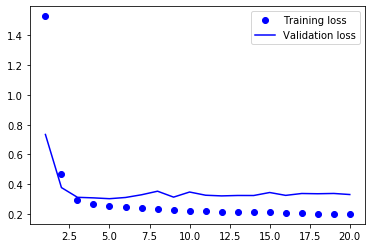

In [13]:
# plotting the result
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

plt.show()

In [13]:
# Training and evaluating a GRU-based model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)



Epoch 1/20
500/500 [==============================] - 97s 194ms/step - loss: 0.3024 - val_loss: 0.2560
Epoch 2/20
500/500 [==============================] - 96s 193ms/step - loss: 0.2832 - val_loss: 0.2919
Epoch 3/20
500/500 [==============================] - 97s 193ms/step - loss: 0.2794 - val_loss: 0.2974
Epoch 4/20
500/500 [==============================] - 97s 193ms/step - loss: 0.2735 - val_loss: 0.2786
Epoch 5/20
500/500 [==============================] - 96s 192ms/step - loss: 0.2703 - val_loss: 0.3298
Epoch 6/20
500/500 [==============================] - 96s 192ms/step - loss: 0.2665 - val_loss: 0.3168
Epoch 7/20
500/500 [==============================] - 98s 196ms/step - loss: 0.2626 - val_loss: 0.3012
Epoch 8/20
500/500 [==============================] - 101s 202ms/step - loss: 0.2577 - val_loss: 0.3136
Epoch 9/20
500/500 [==============================] - 100s 200ms/step - loss: 0.2525 - val_loss: 0.2831
Epoch 10/20
500/500 [==============================] - 99s 199ms/step -

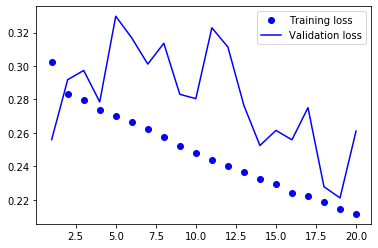

In [14]:
# plotting the result
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

plt.show()

In [10]:
# using recurrent dropout to fight overfitting
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, rmsprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mean_squared_logarithmic_error')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 118s 235ms/step - loss: 35.8046 - val_loss: 0.0234
Epoch 2/40
500/500 [==============================] - 115s 230ms/step - loss: 1.8056 - val_loss: 0.0058
Epoch 3/40
500/500 [==============================] - 115s 230ms/step - loss: 1.1297 - val_loss: 0.0062
Epoch 4/40
500/500 [==============================] - 116s 231ms/step - loss: 0.6540 - val_loss: 0.0059
Epoch 5/40
500/500 [==============================] - 119s 238ms/step - loss: 0.5171 - val_loss: 0.0060
Epoch 6/40
500/500 [==============================] - 115s 230ms/step - loss: 0.2602 - val_loss: 0.0064
Epoch 7/40
500/500 [==============================] - 115s 230ms/step - loss: 0.2859 - val_loss: 0.0057
Epoch 8/40
500/500 [==============================] - 115s 230ms/step - loss: 0.3957 - val_loss: 0.0057
Epoch 9/40
500/500 [==============================] - 115s 230ms/step - loss: 0.6197 - val_loss: 0.0055
Epoch 10/40
500/500 [==============================] - 120s 239

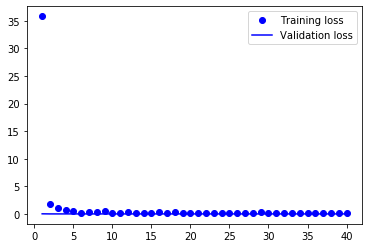

In [11]:
# plotting the result
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()

plt.show()

In [19]:
# Stacking recurrent layers
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 259s 518ms/step - loss: nan - val_loss: nan
Epoch 2/5
500/500 [==============================] - 243s 486ms/step - loss: nan - val_loss: nan
Epoch 3/5
500/500 [==============================] - 237s 474ms/step - loss: nan - val_loss: nan
Epoch 4/5
500/500 [==============================] - 237s 475ms/step - loss: nan - val_loss: nan
Epoch 5/5
500/500 [==============================] - 242s 484ms/step - loss: nan - val_loss: nan


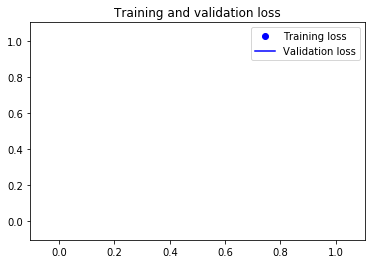

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
# Using bidirectional RNNs
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [23]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 113s 226ms/step - loss: 0.4802 - val_loss: 0.1678
Epoch 2/20
500/500 [==============================] - 111s 221ms/step - loss: 0.4474 - val_loss: 0.2088
Epoch 3/20
500/500 [==============================] - 110s 220ms/step - loss: 0.4044 - val_loss: 0.1607
Epoch 4/20
500/500 [==============================] - 111s 221ms/step - loss: 0.3657 - val_loss: 0.1908
Epoch 5/20
500/500 [==============================] - 110s 220ms/step - loss: 0.3337 - val_loss: 0.1572
Epoch 6/20
500/500 [==============================] - 110s 221ms/step - loss: 0.3130 - val_loss: 0.1593
Epoch 7/20
500/500 [==============================] - 110s 221ms/step - loss: 0.3000 - val_loss: 0.2452
Epoch 8/20
500/500 [==============================] - 111s 222ms/step - loss: 0.2893 - val_loss: 0.1443
Epoch 9/20
500/500 [==============================] - 111s 221ms/step - loss: 0.2791 - val_loss: 0.1541
Epoch 10/20
500/500 [==============================] - 111s 221m

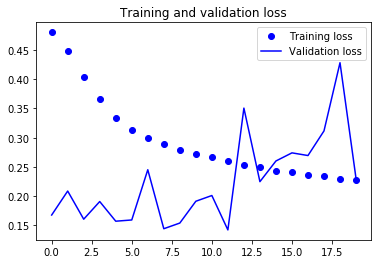

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
# training a bidirectional gru
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 206s 411ms/step - loss: 0.2952 - val_loss: 0.1640
Epoch 2/5
500/500 [==============================] - 204s 408ms/step - loss: 0.2747 - val_loss: 0.1545
Epoch 3/5
500/500 [==============================] - 203s 406ms/step - loss: 0.2696 - val_loss: 0.1648
Epoch 4/5
500/500 [==============================] - 203s 406ms/step - loss: 0.2622 - val_loss: 0.1551
Epoch 5/5
500/500 [==============================] - 203s 406ms/step - loss: 0.2585 - val_loss: 0.1290
